In [1]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# evaluation functions
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [4]:
# wrangle function

def wrangle(X):
    X = X.copy()
    
    # Engineer date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # Merge tube data
    tube = pd.read_csv('competition_data/tube.csv')
    X = X.merge(tube, how='left')
    
    # Engineer features from bill_of_materials
    materials = pd.read_csv('competition_data/bill_of_materials.csv')
    
    materials['components_total'] = (materials['quantity_1'].fillna(0) + 
                                     materials['quantity_2'].fillna(0) + 
                                     materials['quantity_3'].fillna(0) + 
                                     materials['quantity_4'].fillna(0) + 
                                     materials['quantity_5'].fillna(0) + 
                                     materials['quantity_6'].fillna(0) + 
                                     materials['quantity_7'].fillna(0) + 
                                     materials['quantity_8'].fillna(0))

    materials['components_distinct'] = (materials['component_id_1'].notnull().astype(int) + 
                                        materials['component_id_2'].notnull().astype(int) + 
                                        materials['component_id_3'].notnull().astype(int) + 
                                        materials['component_id_4'].notnull().astype(int) + 
                                        materials['component_id_5'].notnull().astype(int) + 
                                        materials['component_id_6'].notnull().astype(int) + 
                                        materials['component_id_7'].notnull().astype(int) + 
                                        materials['component_id_8'].notnull().astype(int))
    
    # Engineer features from components and bill_of_materials
    components = pd.read_csv('competition_data/components.csv')
    
    # create dictionary to map component_id to component_id_type
    component_dict = components[['component_id', 'component_type_id']].set_index('component_id').to_dict(orient='dict')
    component_dict = component_dict['component_type_id']
    
    # use the dictionary to replace component_id in bill_of_materials with component_id_type
    materials_type = materials.replace(component_dict)
    
    # create a function to return the tally of components with a specified component type in a row
    def count(row):
        tally=0
        for num in range(1,6):
            name = 'component_id_' + str(num)
            quantity = 'quantity_' + str(num)
            if row[name]==item:
                tally += row[quantity]
            return tally
    
    # get a list of unique component types
    component_type_list = components.component_type_id.unique().tolist()
    
    # iterate over the list of component types and apply the function to 
    # create a feature with the row tallies
    for item in component_type_list:
        materials_type[item] = materials_type.apply(count, axis=1)
    
    # Merge selected features from bill_of_materials
    # Just use the first component_id, ignore the others for now!
    features = ['tube_assembly_id', 'component_id_1', 'components_total', 'components_distinct',
                'OTHER', 'CP-024', 'CP-026', 'CP-028', 'CP-014', 
                'CP-018', 'CP-001', 'CP-008', 'CP-009', 'CP-002', 
                'CP-010', 'CP-021', 'CP-011', 'CP-015', 'CP-027',
                'CP-003', 'CP-004', 'CP-005', 'CP-019', 'CP-025', 
                'CP-006', 'CP-016', 'CP-020', 'CP-012', 'CP-022', 
                'CP-007', 'CP-017', 'CP-023', 'CP-029']
    X = X.merge(materials_type[features], how='left')
    
    # Get component_type_id (has lower cardinality than component_id)
    components = pd.read_csv('competition_data/components.csv')
    components = components.rename(columns={'component_id': 'component_id_1'})
    features = ['component_id_1', 'component_type_id']
    X = X.merge(components[features], how='left')
    
    # Count the number of specs for the tube assembly
    specs = pd.read_csv('competition_data/specs.csv')
    specs['specs_total'] = specs.drop(columns=['tube_assembly_id']).count(axis=1)
    features = ['tube_assembly_id', 'specs_total', 'spec1']
    X = X.merge(specs[features], how='left')
    
    # Drop tube_assembly_id because our goal is to predict unknown assemblies
    X = X.drop(columns='tube_assembly_id')
    
    return X

In [5]:
# read data
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

trainval.shape, test.shape

((30213, 8), (30235, 8))

In [6]:
# Split into train & validation sets
# All rows for a given tube_assembly_id should go in either train or validation
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=42)
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]

In [7]:
# Wrangle train, validation, and test sets
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [8]:
# Arrange X matrix and y vector (log-transformed)
target = 'cost'
X_train = train.drop(columns=target)
X_val = val.drop(columns=target)
X_test = test.drop(columns='id')
y_train = train[target]
y_val = val[target]
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [9]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
)

In [10]:
# Fit
pipeline.fit(X_train, y_train_log)

Pipeline(memory=None,
     steps=[('ordinalencoder', OrdinalEncoder(cols=['supplier', 'bracket_pricing', 'material_id', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'component_id_1', 'component_type_id', 'spec1'],
        drop_invariant=False, handle_missing='value',
        handle_unknown='value',
      ...imators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [11]:
# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

Validation Error 0.27729840273507944


In [12]:
# prediction function
def generate_submission(estimator, X_test, filename):
    y_pred_log = estimator.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
    submission = pd.read_csv('sample_submission.csv')
    submission['cost'] = y_pred
    submission.to_csv(filename, index=False)

In [13]:
# make predictions
generate_submission(pipeline, X_test, 'submission-10.csv')

## Now lets do a gradient boosting model

In [14]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.fit_transform(X_val)

In [23]:
eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

model = XGBRegressor(n_estimators=10000, n_jobs=-1, eta=0.085, max_depth=7)
model.fit(X_train_encoded, y_train_log, eval_set=eval_set, eval_metric='rmse',
         early_stopping_rounds=1000)

[0]	validation_0-rmse:1.71101	validation_1-rmse:1.70151
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
[1]	validation_0-rmse:1.54853	validation_1-rmse:1.54099
[2]	validation_0-rmse:1.40287	validation_1-rmse:1.39728
[3]	validation_0-rmse:1.27214	validation_1-rmse:1.26849
[4]	validation_0-rmse:1.15496	validation_1-rmse:1.15344
[5]	validation_0-rmse:1.05026	validation_1-rmse:1.05004
[6]	validation_0-rmse:0.956209	validation_1-rmse:0.958078
[7]	validation_0-rmse:0.872345	validation_1-rmse:0.876998
[8]	validation_0-rmse:0.797387	validation_1-rmse:0.803734
[9]	validation_0-rmse:0.730463	validation_1-rmse:0.739612
[10]	validation_0-rmse:0.671167	validation_1-rmse:0.683328
[11]	validation_0-rmse:0.617928	validation_1-rmse:0.632545
[12]	validation_0-rmse:0.570627	validation_1-rmse:0.587651
[13]	validation_0-rmse:0.529302	validation_1-rmse:0.549318
[14]	validation_0-rmse:0.492653	val

[137]	validation_0-rmse:0.148242	validation_1-rmse:0.258827
[138]	validation_0-rmse:0.14783	validation_1-rmse:0.25877
[139]	validation_0-rmse:0.147648	validation_1-rmse:0.258712
[140]	validation_0-rmse:0.147596	validation_1-rmse:0.258671
[141]	validation_0-rmse:0.14715	validation_1-rmse:0.258344
[142]	validation_0-rmse:0.146849	validation_1-rmse:0.258169
[143]	validation_0-rmse:0.146697	validation_1-rmse:0.258111
[144]	validation_0-rmse:0.146273	validation_1-rmse:0.258162
[145]	validation_0-rmse:0.1459	validation_1-rmse:0.258009
[146]	validation_0-rmse:0.145152	validation_1-rmse:0.257891
[147]	validation_0-rmse:0.145019	validation_1-rmse:0.257909
[148]	validation_0-rmse:0.14454	validation_1-rmse:0.257862
[149]	validation_0-rmse:0.144496	validation_1-rmse:0.257799
[150]	validation_0-rmse:0.144355	validation_1-rmse:0.257725
[151]	validation_0-rmse:0.143932	validation_1-rmse:0.257646
[152]	validation_0-rmse:0.143905	validation_1-rmse:0.257609
[153]	validation_0-rmse:0.143473	validation_1-

[274]	validation_0-rmse:0.112454	validation_1-rmse:0.250471
[275]	validation_0-rmse:0.111906	validation_1-rmse:0.250323
[276]	validation_0-rmse:0.111504	validation_1-rmse:0.250295
[277]	validation_0-rmse:0.110961	validation_1-rmse:0.250285
[278]	validation_0-rmse:0.110614	validation_1-rmse:0.250259
[279]	validation_0-rmse:0.110216	validation_1-rmse:0.250162
[280]	validation_0-rmse:0.110055	validation_1-rmse:0.250157
[281]	validation_0-rmse:0.110042	validation_1-rmse:0.25015
[282]	validation_0-rmse:0.109945	validation_1-rmse:0.250146
[283]	validation_0-rmse:0.109519	validation_1-rmse:0.250105
[284]	validation_0-rmse:0.1095	validation_1-rmse:0.250089
[285]	validation_0-rmse:0.109316	validation_1-rmse:0.250075
[286]	validation_0-rmse:0.108971	validation_1-rmse:0.250132
[287]	validation_0-rmse:0.108938	validation_1-rmse:0.25016
[288]	validation_0-rmse:0.108456	validation_1-rmse:0.250059
[289]	validation_0-rmse:0.108192	validation_1-rmse:0.250019
[290]	validation_0-rmse:0.108167	validation_

[412]	validation_0-rmse:0.09107	validation_1-rmse:0.247916
[413]	validation_0-rmse:0.091017	validation_1-rmse:0.247889
[414]	validation_0-rmse:0.090793	validation_1-rmse:0.247864
[415]	validation_0-rmse:0.090741	validation_1-rmse:0.247868
[416]	validation_0-rmse:0.090627	validation_1-rmse:0.247825
[417]	validation_0-rmse:0.090564	validation_1-rmse:0.247792
[418]	validation_0-rmse:0.090556	validation_1-rmse:0.247788
[419]	validation_0-rmse:0.090482	validation_1-rmse:0.247761
[420]	validation_0-rmse:0.090275	validation_1-rmse:0.247745
[421]	validation_0-rmse:0.09017	validation_1-rmse:0.24773
[422]	validation_0-rmse:0.089961	validation_1-rmse:0.247712
[423]	validation_0-rmse:0.089644	validation_1-rmse:0.247666
[424]	validation_0-rmse:0.08942	validation_1-rmse:0.247689
[425]	validation_0-rmse:0.089117	validation_1-rmse:0.247649
[426]	validation_0-rmse:0.089051	validation_1-rmse:0.247647
[427]	validation_0-rmse:0.088781	validation_1-rmse:0.247551
[428]	validation_0-rmse:0.088445	validation_

[550]	validation_0-rmse:0.074968	validation_1-rmse:0.246493
[551]	validation_0-rmse:0.074942	validation_1-rmse:0.246513
[552]	validation_0-rmse:0.074929	validation_1-rmse:0.246512
[553]	validation_0-rmse:0.074911	validation_1-rmse:0.246525
[554]	validation_0-rmse:0.07487	validation_1-rmse:0.246521
[555]	validation_0-rmse:0.074838	validation_1-rmse:0.246509
[556]	validation_0-rmse:0.074656	validation_1-rmse:0.246483
[557]	validation_0-rmse:0.074644	validation_1-rmse:0.246462
[558]	validation_0-rmse:0.07463	validation_1-rmse:0.246453
[559]	validation_0-rmse:0.074467	validation_1-rmse:0.246454
[560]	validation_0-rmse:0.074451	validation_1-rmse:0.24645
[561]	validation_0-rmse:0.074435	validation_1-rmse:0.246455
[562]	validation_0-rmse:0.074069	validation_1-rmse:0.246437
[563]	validation_0-rmse:0.073891	validation_1-rmse:0.246372
[564]	validation_0-rmse:0.073727	validation_1-rmse:0.246363
[565]	validation_0-rmse:0.073705	validation_1-rmse:0.246343
[566]	validation_0-rmse:0.073626	validation

[688]	validation_0-rmse:0.063084	validation_1-rmse:0.246367
[689]	validation_0-rmse:0.062977	validation_1-rmse:0.246355
[690]	validation_0-rmse:0.062848	validation_1-rmse:0.246355
[691]	validation_0-rmse:0.062746	validation_1-rmse:0.246383
[692]	validation_0-rmse:0.062597	validation_1-rmse:0.246382
[693]	validation_0-rmse:0.0625	validation_1-rmse:0.246394
[694]	validation_0-rmse:0.062342	validation_1-rmse:0.246406
[695]	validation_0-rmse:0.062218	validation_1-rmse:0.246404
[696]	validation_0-rmse:0.062123	validation_1-rmse:0.246398
[697]	validation_0-rmse:0.061922	validation_1-rmse:0.246429
[698]	validation_0-rmse:0.061873	validation_1-rmse:0.246431
[699]	validation_0-rmse:0.061797	validation_1-rmse:0.246444
[700]	validation_0-rmse:0.061675	validation_1-rmse:0.246489
[701]	validation_0-rmse:0.061656	validation_1-rmse:0.246492
[702]	validation_0-rmse:0.061652	validation_1-rmse:0.246496
[703]	validation_0-rmse:0.061498	validation_1-rmse:0.246492
[704]	validation_0-rmse:0.061495	validatio

[825]	validation_0-rmse:0.054435	validation_1-rmse:0.246221
[826]	validation_0-rmse:0.054365	validation_1-rmse:0.246194
[827]	validation_0-rmse:0.054342	validation_1-rmse:0.246206
[828]	validation_0-rmse:0.05428	validation_1-rmse:0.246194
[829]	validation_0-rmse:0.054193	validation_1-rmse:0.246175
[830]	validation_0-rmse:0.054176	validation_1-rmse:0.246179
[831]	validation_0-rmse:0.054173	validation_1-rmse:0.246177
[832]	validation_0-rmse:0.054169	validation_1-rmse:0.246173
[833]	validation_0-rmse:0.054165	validation_1-rmse:0.246169
[834]	validation_0-rmse:0.054164	validation_1-rmse:0.246171
[835]	validation_0-rmse:0.054094	validation_1-rmse:0.246188
[836]	validation_0-rmse:0.054063	validation_1-rmse:0.246186
[837]	validation_0-rmse:0.053959	validation_1-rmse:0.246185
[838]	validation_0-rmse:0.053935	validation_1-rmse:0.246165
[839]	validation_0-rmse:0.053863	validation_1-rmse:0.246158
[840]	validation_0-rmse:0.053822	validation_1-rmse:0.246166
[841]	validation_0-rmse:0.053745	validati

[963]	validation_0-rmse:0.04828	validation_1-rmse:0.246055
[964]	validation_0-rmse:0.048171	validation_1-rmse:0.246068
[965]	validation_0-rmse:0.048065	validation_1-rmse:0.246086
[966]	validation_0-rmse:0.04804	validation_1-rmse:0.246062
[967]	validation_0-rmse:0.047987	validation_1-rmse:0.24606
[968]	validation_0-rmse:0.04791	validation_1-rmse:0.246075
[969]	validation_0-rmse:0.047891	validation_1-rmse:0.246065
[970]	validation_0-rmse:0.047759	validation_1-rmse:0.246055
[971]	validation_0-rmse:0.047642	validation_1-rmse:0.24604
[972]	validation_0-rmse:0.047587	validation_1-rmse:0.246067
[973]	validation_0-rmse:0.047524	validation_1-rmse:0.246058
[974]	validation_0-rmse:0.047499	validation_1-rmse:0.246067
[975]	validation_0-rmse:0.047384	validation_1-rmse:0.246065
[976]	validation_0-rmse:0.047328	validation_1-rmse:0.246083
[977]	validation_0-rmse:0.047323	validation_1-rmse:0.246086
[978]	validation_0-rmse:0.047263	validation_1-rmse:0.246094
[979]	validation_0-rmse:0.047175	validation_1

[1099]	validation_0-rmse:0.042655	validation_1-rmse:0.246088
[1100]	validation_0-rmse:0.042624	validation_1-rmse:0.246086
[1101]	validation_0-rmse:0.042586	validation_1-rmse:0.246096
[1102]	validation_0-rmse:0.042558	validation_1-rmse:0.246091
[1103]	validation_0-rmse:0.042537	validation_1-rmse:0.2461
[1104]	validation_0-rmse:0.042474	validation_1-rmse:0.24609
[1105]	validation_0-rmse:0.042442	validation_1-rmse:0.246102
[1106]	validation_0-rmse:0.042358	validation_1-rmse:0.24611
[1107]	validation_0-rmse:0.042314	validation_1-rmse:0.24609
[1108]	validation_0-rmse:0.042309	validation_1-rmse:0.246086
[1109]	validation_0-rmse:0.042272	validation_1-rmse:0.246087
[1110]	validation_0-rmse:0.042266	validation_1-rmse:0.246083
[1111]	validation_0-rmse:0.042241	validation_1-rmse:0.246082
[1112]	validation_0-rmse:0.042163	validation_1-rmse:0.24608
[1113]	validation_0-rmse:0.042123	validation_1-rmse:0.246076
[1114]	validation_0-rmse:0.042091	validation_1-rmse:0.246075
[1115]	validation_0-rmse:0.042

[1234]	validation_0-rmse:0.037799	validation_1-rmse:0.246478
[1235]	validation_0-rmse:0.037766	validation_1-rmse:0.246467
[1236]	validation_0-rmse:0.037711	validation_1-rmse:0.246469
[1237]	validation_0-rmse:0.037679	validation_1-rmse:0.24647
[1238]	validation_0-rmse:0.037593	validation_1-rmse:0.246473
[1239]	validation_0-rmse:0.037539	validation_1-rmse:0.246454
[1240]	validation_0-rmse:0.037514	validation_1-rmse:0.246454
[1241]	validation_0-rmse:0.037469	validation_1-rmse:0.246449
[1242]	validation_0-rmse:0.03745	validation_1-rmse:0.246447
[1243]	validation_0-rmse:0.037408	validation_1-rmse:0.246458
[1244]	validation_0-rmse:0.037391	validation_1-rmse:0.246455
[1245]	validation_0-rmse:0.037307	validation_1-rmse:0.246471
[1246]	validation_0-rmse:0.037282	validation_1-rmse:0.246469
[1247]	validation_0-rmse:0.037241	validation_1-rmse:0.246467
[1248]	validation_0-rmse:0.037212	validation_1-rmse:0.246458
[1249]	validation_0-rmse:0.037211	validation_1-rmse:0.246458
[1250]	validation_0-rmse:0

[1369]	validation_0-rmse:0.034514	validation_1-rmse:0.246549
[1370]	validation_0-rmse:0.034502	validation_1-rmse:0.246545
[1371]	validation_0-rmse:0.034475	validation_1-rmse:0.246535
[1372]	validation_0-rmse:0.034474	validation_1-rmse:0.246535
[1373]	validation_0-rmse:0.034421	validation_1-rmse:0.246535
[1374]	validation_0-rmse:0.034382	validation_1-rmse:0.246539
[1375]	validation_0-rmse:0.034348	validation_1-rmse:0.246553
[1376]	validation_0-rmse:0.034327	validation_1-rmse:0.246555
[1377]	validation_0-rmse:0.03428	validation_1-rmse:0.246566
[1378]	validation_0-rmse:0.034269	validation_1-rmse:0.246565
[1379]	validation_0-rmse:0.034247	validation_1-rmse:0.246561
[1380]	validation_0-rmse:0.034175	validation_1-rmse:0.246566
[1381]	validation_0-rmse:0.034155	validation_1-rmse:0.24657
[1382]	validation_0-rmse:0.034134	validation_1-rmse:0.246571
[1383]	validation_0-rmse:0.034082	validation_1-rmse:0.246558
[1384]	validation_0-rmse:0.034072	validation_1-rmse:0.246558
[1385]	validation_0-rmse:0

[1504]	validation_0-rmse:0.031275	validation_1-rmse:0.246628
[1505]	validation_0-rmse:0.03122	validation_1-rmse:0.246633
[1506]	validation_0-rmse:0.031166	validation_1-rmse:0.246631
[1507]	validation_0-rmse:0.031122	validation_1-rmse:0.246637
[1508]	validation_0-rmse:0.031059	validation_1-rmse:0.246632
[1509]	validation_0-rmse:0.031033	validation_1-rmse:0.246633
[1510]	validation_0-rmse:0.031003	validation_1-rmse:0.246624
[1511]	validation_0-rmse:0.03098	validation_1-rmse:0.24663
[1512]	validation_0-rmse:0.030969	validation_1-rmse:0.246624
[1513]	validation_0-rmse:0.030959	validation_1-rmse:0.246619
[1514]	validation_0-rmse:0.030956	validation_1-rmse:0.246618
[1515]	validation_0-rmse:0.030904	validation_1-rmse:0.246607
[1516]	validation_0-rmse:0.030891	validation_1-rmse:0.246601
[1517]	validation_0-rmse:0.030886	validation_1-rmse:0.246602
[1518]	validation_0-rmse:0.030873	validation_1-rmse:0.246606
[1519]	validation_0-rmse:0.030841	validation_1-rmse:0.246607
[1520]	validation_0-rmse:0.

[1639]	validation_0-rmse:0.029034	validation_1-rmse:0.246565
[1640]	validation_0-rmse:0.029027	validation_1-rmse:0.246558
[1641]	validation_0-rmse:0.029006	validation_1-rmse:0.246565
[1642]	validation_0-rmse:0.029003	validation_1-rmse:0.246564
[1643]	validation_0-rmse:0.02899	validation_1-rmse:0.24656
[1644]	validation_0-rmse:0.028987	validation_1-rmse:0.246559
[1645]	validation_0-rmse:0.028981	validation_1-rmse:0.246562
[1646]	validation_0-rmse:0.028953	validation_1-rmse:0.246554
[1647]	validation_0-rmse:0.028938	validation_1-rmse:0.24655
[1648]	validation_0-rmse:0.02889	validation_1-rmse:0.24655
[1649]	validation_0-rmse:0.028863	validation_1-rmse:0.246545
[1650]	validation_0-rmse:0.028845	validation_1-rmse:0.246547
[1651]	validation_0-rmse:0.028828	validation_1-rmse:0.24655
[1652]	validation_0-rmse:0.028823	validation_1-rmse:0.246554
[1653]	validation_0-rmse:0.028805	validation_1-rmse:0.246562
[1654]	validation_0-rmse:0.028798	validation_1-rmse:0.246567
[1655]	validation_0-rmse:0.028

[1774]	validation_0-rmse:0.026979	validation_1-rmse:0.246618
[1775]	validation_0-rmse:0.02696	validation_1-rmse:0.246619
[1776]	validation_0-rmse:0.026928	validation_1-rmse:0.246628
[1777]	validation_0-rmse:0.026875	validation_1-rmse:0.246628
[1778]	validation_0-rmse:0.026871	validation_1-rmse:0.24663
[1779]	validation_0-rmse:0.026845	validation_1-rmse:0.246632
[1780]	validation_0-rmse:0.026839	validation_1-rmse:0.246632
[1781]	validation_0-rmse:0.026825	validation_1-rmse:0.24663
[1782]	validation_0-rmse:0.026801	validation_1-rmse:0.246637
[1783]	validation_0-rmse:0.026792	validation_1-rmse:0.246636
[1784]	validation_0-rmse:0.02677	validation_1-rmse:0.246631
[1785]	validation_0-rmse:0.026759	validation_1-rmse:0.246632
[1786]	validation_0-rmse:0.026729	validation_1-rmse:0.246644
[1787]	validation_0-rmse:0.026726	validation_1-rmse:0.246644
[1788]	validation_0-rmse:0.026724	validation_1-rmse:0.246644
[1789]	validation_0-rmse:0.026705	validation_1-rmse:0.246642
[1790]	validation_0-rmse:0.0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.085, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=10000, n_jobs=-1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [24]:
X_test_encoded = encoder.transform(X_test)
generate_submission(model, X_test_encoded, 'submission-13.csv')

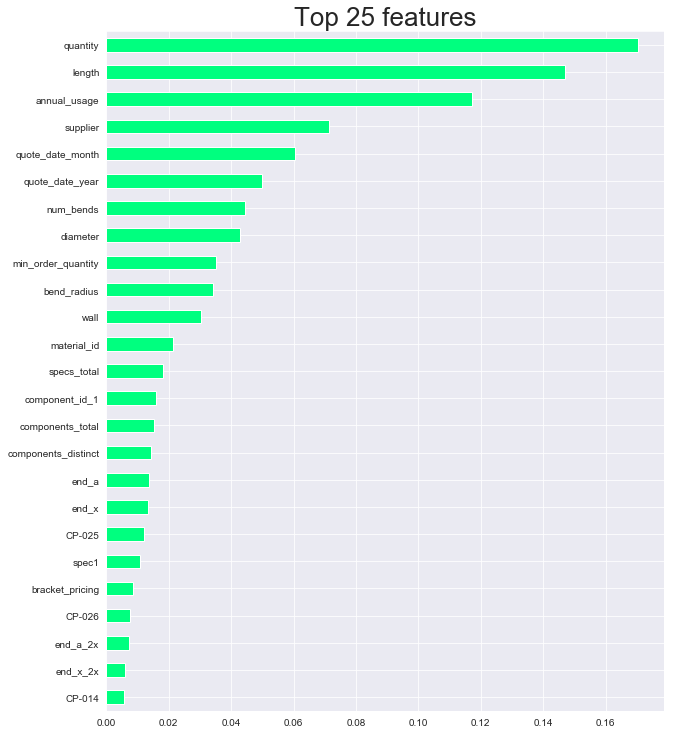

In [25]:
# Get feature importances
importances = pd.Series(model.feature_importances_, X_train.columns)

sns.set_style('darkgrid')
# Plot feature importances
n = 25
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features', fontsize=26)
importances.sort_values()[-n:].plot.barh(color='springgreen');

In [19]:
X_train.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,quote_date_year,quote_date_month,material_id,diameter,wall,...,CP-020,CP-012,CP-022,CP-007,CP-017,CP-023,CP-029,component_type_id,specs_total,spec1
0,S-0066,0,0,Yes,1,2013,7,SP-0019,6.35,0.71,...,0.0,0.0,0.0,0.0,0,0,0,NaN,0,NaN
1,S-0066,0,0,Yes,2,2013,7,SP-0019,6.35,0.71,...,0.0,0.0,0.0,0.0,0,0,0,NaN,0,NaN
2,S-0066,0,0,Yes,5,2013,7,SP-0019,6.35,0.71,...,0.0,0.0,0.0,0.0,0,0,0,NaN,0,NaN
3,S-0066,0,0,Yes,10,2013,7,SP-0019,6.35,0.71,...,0.0,0.0,0.0,0.0,0,0,0,NaN,0,NaN
4,S-0066,0,0,Yes,25,2013,7,SP-0019,6.35,0.71,...,0.0,0.0,0.0,0.0,0,0,0,NaN,0,NaN


In [26]:
# maybe I should one-hot encode these?
# i wonder if the ordinal encoding is creating noise
X_train['material_id'].nunique()

16

In [27]:
X_train['supplier'].nunique()

52